In [1]:
import ssl
import urllib.request
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.nn import functional as F
%load_ext autoreload

# Set autoreload to automatically reload all modules before executing code
%autoreload 2

# Create an SSL context that does not verify the certificate
ssl._create_default_https_context = ssl._create_unverified_context
from src.anti_spoof.fas import flip_it

Matplotlib is building the font cache; this may take a moment.
/Users/martynagrygiel/Documents/studia/sem3/biometrics-assignment-3/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# FLIP

In [2]:
model = flip_it()
model_path = "data/pretrained_models/casia_flip_mcl.pth.tar"
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint["state_dict"], strict=False)
model.eval()


cpu


flip_it(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLin

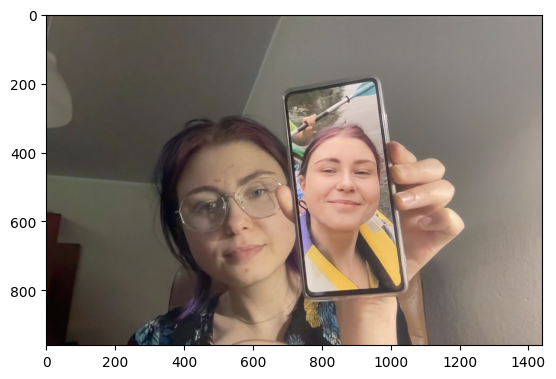

In [3]:
img1_path = "data/spoof_test/sp1.jpg"
img = Image.open(img1_path)
plt.imshow(img)

In [4]:
preprocess = transforms.Compose(
[
transforms.Resize([224, 224]),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485], std=[0.229])
]
)

In [5]:
input = preprocess(img).unsqueeze(0)
cls_out, feature = model(input, norm_flag=True) # for FLIP-V and FLIP-IT model
prob = F.softmax(cls_out, dim=1).cpu().data.numpy()
prob

array([[0.9918783 , 0.00812176]], dtype=float32)

In [6]:
((prob[:, 1])>= 0.5).astype(int)[0] # 0 == spoof 1 == real

0

# Datasouls antispoof


In [19]:
from pylab import imshow
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import seaborn as sns
import pandas as pd
import albumentations as albu

from albumentations.pytorch.transforms import ToTensorV2
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
from iglovikov_helper_functions.utils.image_utils import load_rgb
from datasouls_antispoof.pre_trained_models import create_model
from datasouls_antispoof.class_mapping import class_mapping

In [27]:
model = create_model("tf_efficientnet_b3_ns")
model.eval();
img1_path = "data/spoof_test/spoof_test.jpg"
img = load_rgb(img1_path)

transform = albu.Compose([albu.PadIfNeeded(min_height=400, min_width=400),
                          albu.CenterCrop(height=400, width=400), 
                          albu.Normalize(p=1), 
                          albu.pytorch.ToTensorV2(p=1)], p=1)

In [28]:
with torch.no_grad():
  prediction = model(torch.unsqueeze(transform(image=img)['image'], 0)).numpy()[0]

prediction

array([9.9999809e-01, 3.1340408e-10, 1.9121067e-06, 2.6679465e-09],
      dtype=float32)

<Axes: xlabel='prediction', ylabel='class_name'>

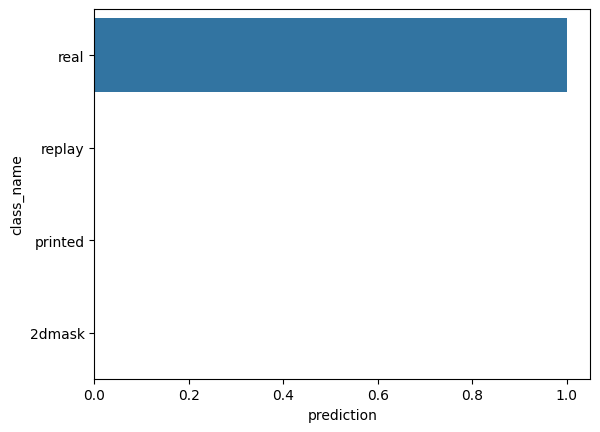

In [29]:
df = pd.DataFrame({"prediction": prediction, "class_name": class_mapping.keys()})
sns.barplot(data=df, x="prediction", y="class_name")

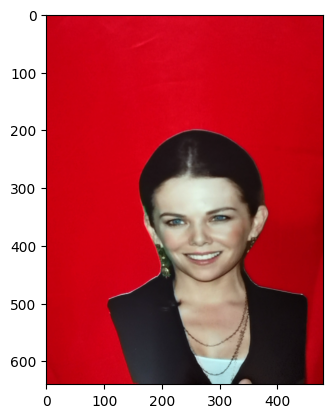

In [30]:


model = create_model("tf_efficientnet_b3_ns")
model.eval();
img1_path = "data/CelebA_Spoof/Data/test/5695/spoof/496336.png"
img = load_rgb(img1_path)
plt.imshow(img)

<Axes: xlabel='prediction', ylabel='class_name'>

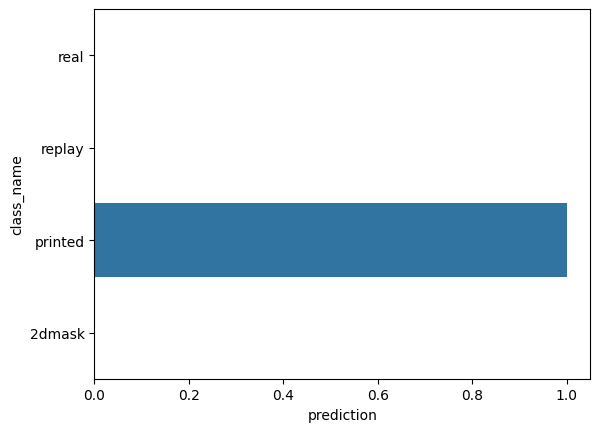

In [31]:
with torch.no_grad():
  prediction = model(torch.unsqueeze(transform(image=img)['image'], 0)).numpy()[0]

df = pd.DataFrame({"prediction": prediction, "class_name": class_mapping.keys()})
sns.barplot(data=df, x="prediction", y="class_name")

# Deepface antispoof

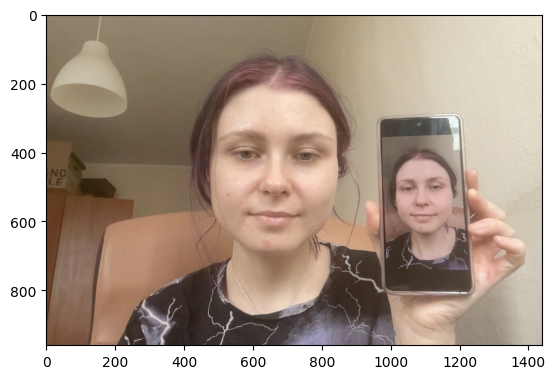

In [25]:
img1_path = "data/spoof_test/spoof_test.jpg"
img = Image.open(img1_path)
plt.imshow(img)

In [33]:
from deepface import DeepFace
face_objs = DeepFace.extract_faces(
    
  img_path="data/spoof_test/sp1.jpg",
  anti_spoofing = True
)
face_objs

[{'face': array([[[0.34117647, 0.33333333, 0.28627451],
          [0.34117647, 0.33333333, 0.28627451],
          [0.34509804, 0.3372549 , 0.29019608],
          ...,
          [0.21176471, 0.19607843, 0.2       ],
          [0.22745098, 0.21176471, 0.21568627],
          [0.24313725, 0.23921569, 0.23137255]],
  
         [[0.34117647, 0.33333333, 0.28627451],
          [0.34509804, 0.3372549 , 0.29019608],
          [0.34901961, 0.34117647, 0.29411765],
          ...,
          [0.21176471, 0.19607843, 0.2       ],
          [0.22745098, 0.21176471, 0.21568627],
          [0.23921569, 0.23529412, 0.22745098]],
  
         [[0.34509804, 0.3372549 , 0.29019608],
          [0.34117647, 0.33333333, 0.28627451],
          [0.34509804, 0.3372549 , 0.29019608],
          ...,
          [0.19215686, 0.17647059, 0.18039216],
          [0.21176471, 0.19607843, 0.2       ],
          [0.22352941, 0.20784314, 0.21176471]],
  
         ...,
  
         [[0.78823529, 0.65882353, 0.5372549 ],
      

In [34]:
assert all(face_obj["is_real"] is True for face_obj in face_objs)

In [35]:
face_objs = DeepFace.extract_faces(
    
  img_path="data/CelebA_Spoof/Data/test/5695/spoof/496336.png",
  anti_spoofing = True
)
face_objs

[{'face': array([[[0.14901961, 0.08235294, 0.04705882],
          [0.13333333, 0.08235294, 0.0627451 ],
          [0.1372549 , 0.07843137, 0.0745098 ],
          ...,
          [0.10588235, 0.07058824, 0.07058824],
          [0.10196078, 0.07058824, 0.07058824],
          [0.10980392, 0.07058824, 0.07058824]],
  
         [[0.14901961, 0.08235294, 0.04705882],
          [0.13333333, 0.08235294, 0.0627451 ],
          [0.13333333, 0.0745098 , 0.06666667],
          ...,
          [0.10588235, 0.07058824, 0.07058824],
          [0.10588235, 0.07058824, 0.07058824],
          [0.10980392, 0.07058824, 0.07058824]],
  
         [[0.14901961, 0.08235294, 0.04705882],
          [0.13333333, 0.08235294, 0.0627451 ],
          [0.13333333, 0.0745098 , 0.06666667],
          ...,
          [0.10588235, 0.07058824, 0.07058824],
          [0.10980392, 0.0745098 , 0.0745098 ],
          [0.10980392, 0.07058824, 0.07058824]],
  
         ...,
  
         [[0.09803922, 0.09411765, 0.10588235],
      

In [36]:
assert all(face_obj["is_real"] is True for face_obj in face_objs)

AssertionError: 